In [25]:
import jax.numpy as jnp
import numpy as np
from jax import config
import matplotlib.pyplot as plt

from pde_model import (
    get_discrete_source, 
    solve_pde, 
    solve_pde_vmap,
)

import sys
sys.path.append("./../linear_Gaussian/")
from Gaussian import Gaussian

config.update("jax_enable_x64", True)

In [26]:
import seaborn as sns
sns.set_theme(style='white', palette='colorblind')
sns.set_context("paper", font_scale=1.5)

# Specific Paul Tol color scheme when comparing different posteriors
colors = {
    'exact': "#4477AA",
    'mean': "#EE6677",
    'eup': "#228833",
    'ep': "#CCBB44",
    'aux': "#888888"
}

In [10]:
rng = np.random.default_rng(5623423)

In [34]:
# grid 
n_grid = 100
xgrid = jnp.linspace(0.0, 1.0, n_grid)

# diffusivity
k = jnp.abs(0.1 + 0.05 * rng.standard_normal(n_grid))

# boundary conditions
left_flux = -1.0
rightbc = 1.0

# source term
source_wells = jnp.array([0.2, 0.4, 0.6, 0.8])
source_strength = 0.8
source_width = 0.05
source = get_discrete_source(xgrid, well_locations=source_wells, 
                             strength=source_strength, width=source_width)

In [35]:
u = solve_pde(xgrid=xgrid, 
              left_flux=left_flux, 
              k=k, 
              source=source, 
              rightbc=rightbc)

### Prior

In [36]:
from gpjax.kernels.stationary import PoweredExponential

prior_kernel = PoweredExponential(lengthscale=0.3, variance=1.0, power=0.3, n_dims=1)
prior_mean = jnp.tile(1.0, n_grid)
prior_cov = prior_kernel.gram(xgrid.reshape((-1,1))).to_dense()
prior = Gaussian(prior_mean, prior_cov, rng=rng)

In [40]:
def plot_marginals(dist, grid, colors, alpha=0.3, n_samp=0):

    fig, ax = plt.subplots()

    # intervals
    sd = np.sqrt(np.diag(dist.cov))
    lower = dist.mean - 2 * sd
    upper = dist.mean + 2 * sd

    ax.fill_between(grid, lower, upper, alpha=alpha, label='+/- 2 sd')
    ax.plot(grid, dist.mean, color='black', label='mean')

    if n_samp > 0:
        samp = dist.sample(n_samp)
        ax.plot(grid, samp.T)
    ax.legend()

    plt.close()
    return fig, ax

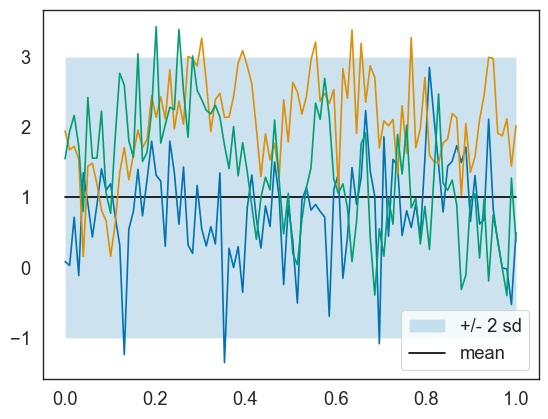

In [43]:
fig_prior, ax_prior = plot_marginals(prior, xgrid, colors, alpha=0.2, n_samp=3)

display(fig_prior)